# The mathematically perfect cappuccino
Getting the perfect foam cap on your home-made cappuccino can be a difficult task for any coffee-lover. Both the height of the foam cap and the rate of decay are difficult to predict ahead of time. Using multilevel modelling we can estimate your coffee's foam height.

In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import optimize, integrate
import pints
sb.set_palette('rainbow_r')


## Background: foam formation in milky coffees
Water does not normally form a stable foam, as bubbles rapidly coalesce in order to minimise the surface area - and so the surface tension - of the water. Foam on milk is formed because proteins in milk act as a surfactant which lowers the surface tension of the liquid. This surfactant effect slows the coalescence of bubbles which would normally happen, and so allows bubbles to form which coalesce relatively slowly. In a cup of milky coffee, these bubbles form a foam cap on top of the coffee, which slowly decays in volume as bubbles within the foam coalesce (see https://doi.org/10.1111/j.1471-0307.2010.00629.x).

A reasonable initial model for the height of the foam in the coffee cup seems to be an ordinary differential equation (equation 1). This model assumes that the decay of foam height over time, $\frac{d h}{d t}$, reduces proportionally to the height of the foam, $h$. This seems reasonable as the number of bubbles should be proportional to the volume (and so height) of the foam.

\begin{equation}
\frac{d h}{d t} = -k \cdot h
\tag{1}
\end{equation}

Using this model, the predicted foam height is shown below for an initial foam height of 1cm and a decay rate of 1.

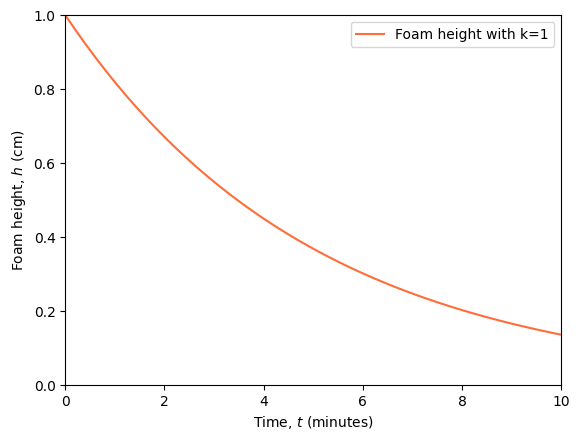

In [28]:
# Parameters
k = 0.2
times = np.linspace(0,10,50)

# A one-compartment PK model is basically an ODE for an exponential decay curve
def ODE(y, t, k):
    """A one-compartment PK model, aka simple exponential decay
    In
    y: y-axis value
    t: x-axis value
    k: gradient parameter
    
    Out: gradient at the given point
    """
    dydt = -k * y
    return dydt

# You can solve ODEs with scipy.integrate.odeint
def simulate(func, parameters, y0, times):
    """Numerically calculate an ODE
    In
    func: function giving the derivative
    parameters: parameters the function requires as input
    y0: y at t=0
    times: array of times at which to calculate y
    
    Out: array of y values at corresponding points in times
    """
    l = integrate.odeint(func, y0, times, (parameters,)) # returns a list of lists
    flatlist = [item for sublist in l for item in sublist] # to single list of 'y's
    return flatlist

# This is what the system output looks like. We don't actually know these values
actual_values = simulate(ODE, k, 1, times)

# Plot the model results
sb.lineplot(x=times, y=actual_values, label='Foam height with k=1')
plt.xlabel('Time, $t$ (minutes)')
plt.ylabel('Foam height, $h$ (cm)')
plt.ylim(0,1)
plt.xlim(0,10)
plt.show()

In this model, two variables dictate the behaviour of the foam: the rate of decay, $k$, and the initial foam height, $h_0$. Ordinarily it is difficult to predict either of these values before we have foamed the milk for our coffee. Because of this, we do not know ahead of time whether our coffee will be the perfect cappuccino or a damp, foamless squib. However, if we know certain initial conditions, such as milk type and age, then it may be possible to predict foam behaviour, and so to know whether our coffee foam will be good, bad, or perfect. 

## Maximum Likelihood Estimation
For a single cup of coffee we can measure the height of the foam at time $t$. We can use this to estimate the parameters $k$ and $h_0$ but each measurement is not perfect - there will be some error between the observed height and its actual value.

_Maximum Likelihood Estimation_ uses a likelihood, defined by the modeller, to estimate the set of parameters most likely to have produced a given, measured set of data. It does this by comparing output from a proposed model to noisy data from the real system: the proposed model that gives the closest output to measured data is said to have the ‘maximum likelihood’. Using Maximum Likelihood Estimation and our observed measurements, we can pinpoint the most likely value of parameters $k$ and $h_0$.

For example, the following example shows a set of measurements that was taken from a single coffee, and the best parameter estimates.

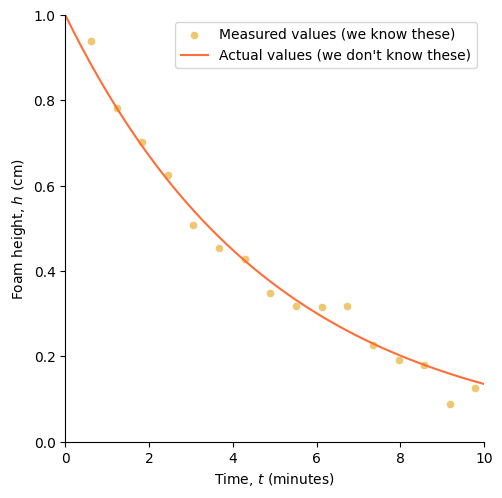

In [29]:
# Make noisy data that we're inferring from. noisy_data is known to us.
n = 3 # Data "sampled" every n time-points
sample_times = times[0::n]
noise = np.random.normal(0, 0.03, math.ceil(len(actual_values)/n))
noisy_data = actual_values[0::n] + noise
sb.relplot(x=sample_times, y=noisy_data, label='Measured values (we know these)', color=sb.color_palette()[1])
sb.lineplot(x=times, y=actual_values, label='Actual values (we don\'t know these)')
plt.xlabel('Time, $t$ (minutes)')
plt.ylabel('Foam height, $h$ (cm)')
plt.ylim(0,1)
plt.xlim(0,10)
plt.show()

In [37]:
def ForwardEuler(func, k, y0, times):
    y = y0
    y_solution = [y0]
    h = times[2] - times[1]
    
    for n in times[:-1]:
        dy = func(y, n, k)
        y = y + h*dy
        y_solution.append(y)
    return y_solution

# Need to make the model into a Pints one
class PintsOneComp(pints.ForwardModel):
    def n_parameters(self):
        return 1
    def simulate(self, parameter, times):
        return ForwardEuler(onecomp, parameter, 1, times)
    
problem = pints.SingleOutputProblem(PintsOneComp(), sample_times, noisy_data)

model = PintsOneComp()
model.simulate(1, [0,0.5,1,1.5,2])

[1, 0.5, 0.25, 0.125, 0.0625]